# VCPI Group assignment Baseline models - Without Data augmentation 

This notebook aims to get the best possible test accuracy on GTSRB - German Traffic Sign Recognition Benchmark, important details:
- It will use CNN for the task;
- Notebook without data augmentation;
- Why do we not apply techniques to balance the dataset?

With data augmentation the accuracy on the training set is generally lower than without data augmentation, nevertheless this accuracy reflects better the capacity of the model to generalize, with the accuracies of the test and validation sets becoming closer. Furthermore, the accuracy in a test set of a model which has suffered data augmentation tends to be higher.

For the task the group chose 3 different networks. The first one, a simplier model from the classes provided the model 2 of notebook x (agora não me lembro), the second one based on a notebook from kaggle and the third constructed itself by the group.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,TensorBoard, EarlyStopping
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, \
            Dense, Activation, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import IPython.display as display

import seaborn as sn
import pandas as pd
import random
import glob
tf.config.run_functions_eagerly(True)
gpus = tf.config.list_physical_devices('GPU')
print(tf.__version__)
if gpus:
    print(gpus)
else:
    print("No GPU available.")


BATCH_SIZE = 32
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Label Overview
classNames = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

classes = np.array([
    '00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007',
    '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015',
    '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023',
    '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031',
    '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039',
    '00040', '00041', '00042'
])

#### Helpful functions

In [3]:
def show_batch(cols, image_batch, label_batch):
    rows = int(BATCH_SIZE / cols) 
    if rows * cols < BATCH_SIZE:
        rows += 1
    width = 3 * rows
    height = 3 * cols
    
    
    f, axes= plt.subplots(rows,cols,figsize=(height,width))
    fig=plt.figure()
    for n in range(BATCH_SIZE):
        
        subplot_title=("class "+ classNames[label_batch[n]==1][0])
        axes.ravel()[n].set_title(subplot_title)  
        axes.ravel()[n].imshow(image_batch[n])
        axes.ravel()[n].axis('off')

    fig.tight_layout()    
    plt.show()
    
    
def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    
    
    
def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show() 


def show_data(s1,l1, s2,l2, labels):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 1-00, bottom = 0.85)
    plt.legend(loc='upper left')
    plt.show()


    
def show_misclassified(predictions, ground_truth, images, num_rows= 5, num_cols=3):
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label, img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(43))
  plt.yticks([])
  thisplot = plt.bar(range(43), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[np.where(true_label)[0][0]].set_color('blue')    

def plot_predictions(predictions, ground_truth, images, num_rows= 5, num_cols=3 ):
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(min(num_images,len(images))):
        gt = np.where(ground_truth[i])[0][0]
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], gt, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], ground_truth)
    plt.tight_layout()
    plt.show()
    

def show_confusion_matrix(model, dataset):
   
    all_labels = []
    all_preds = []

    for images , labels in dataset.take(-1):  
        numpy_labels = labels.numpy()
        numpy_images = images.numpy()
        preds = model.predict(numpy_images, verbose=0)  
        
        all_labels += [np.argmax(x) for x in numpy_labels]
        all_preds += [np.argmax(x) for x in preds]
        
    conf_mat = tf.math.confusion_matrix(all_labels, all_preds)
    # create a mask for values above a threshold
    annot_mask = conf_mat.numpy() > 50
    #conf_mat_norm = conf_mat / conf_mat.sum(axis=1)[:, np.newaxis]

    df_cm = pd.DataFrame(conf_mat.numpy(), range(43), range(43))
    plt.figure(figsize=(20,15))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d',cmap='Blues') # font size

    plt.show()

    res_correct = {i:0 for i in range(43)}
    res_incorrect = {i:0 for i in range(43)}
    for i in range(len(all_preds)):
        if all_preds[i] == all_labels[i]:
            res_correct[all_labels[i]] += 1
        else:
            res_incorrect[all_labels[i]] += 1

    for i in range(len(res_correct)):
        print('class: ', i, ' total images: ', res_correct[i] + res_incorrect[i],' % correct: ', res_correct[i] / (res_correct[i] + res_incorrect[i]))
        
        
        
def plot_distribution(class_distribution, title):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=90)  # rotate x-axis labels for readability
    plt.show()

In [4]:
data_dir = 'D:/Data-UM/DataVCPI'
train_path = 'D:/Data-UM/DataVCPI/train/GTSRB/Final_Training/Images'
test_path = 'D:/Data-UM/DataVCPI/test'
log_and_model_pathS = 'logs/baselineModelLogs/modelS'
log_and_model_pathK = 'logs/baselineModelLogs/modelK'
log_and_model_pathGr = 'logs/baselineModelLogs/modelGr'

In [5]:
train_data_dir=pathlib.Path(train_path)
test_data_dir=pathlib.Path(test_path)

In [6]:
#count the numbers of images in your directory
train_image_count = len(list(train_data_dir.glob('*/*.png')))
test_image_count = len(list(test_data_dir.glob('*/*.png')))

print('Total image train dataset:', train_image_count)
print('Total image test dataset:',test_image_count)   

#Num of categories:
NUM_CLASSES = len(os.listdir(train_path))
print('Number of classes/categories: ',NUM_CLASSES)         

Total image train dataset: 39209
Total image test dataset: 12630
Number of classes/categories:  43


#### Create validation dataset

In [7]:
def create_validation_set(train_ds, validation_ratio):
    train_split = 1.0-validation_ratio
    train_size = int(train_split * train_image_count // BATCH_SIZE)
    train_ds = train_ds.shuffle(buffer_size=train_image_count)

    # Create the validation dataset
    validation_ds = train_ds.skip(train_size)
    train_ds_subset = train_ds.take(train_size)
    
    return train_ds_subset,validation_ds

#### Load the dataset into preprocessing

In [8]:
### Load the dataset into preprocessing
# Use keras.preprocessing method to load data from the directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)


AUTOTUNE = tf.data.AUTOTUNE  #adjust the amount of parallelism depending on the available system resources

Found 39209 files belonging to 43 classes.


c:\Users\USER\Documents\GitHub\VCPI-uminho\computer-vision\.venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 12630 files belonging to 43 classes.


### Check for Unbalanced dataset

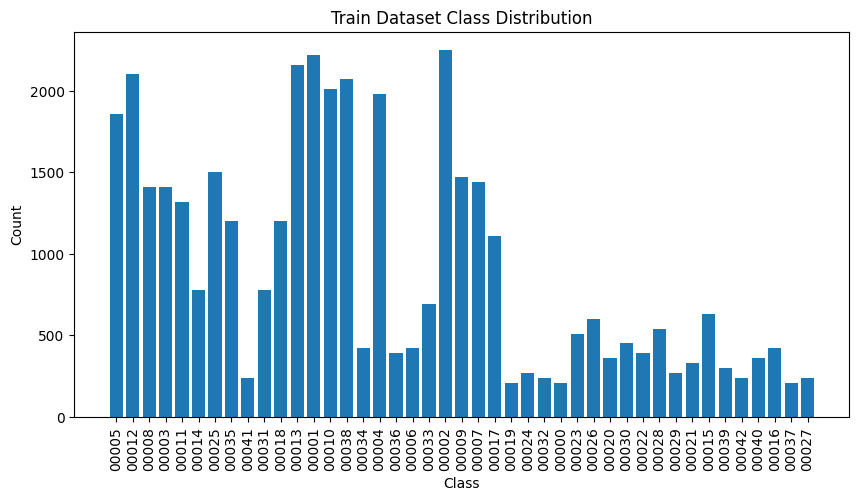

In [16]:
train_class_distribution = {}

for images, labels in train_ds:
    for label in labels.numpy():
        class_name = classes[label]
        if class_name in train_class_distribution:
            train_class_distribution[class_name] += 1
        else:
            train_class_distribution[class_name] = 1
#print(train_class_distribution) 
plot_distribution(train_class_distribution,'Train Dataset Class Distribution')

2023-06-13 03:23:35.527720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [12630]
	 [[{{node Placeholder/_4}}]]
2023-06-13 03:23:35.528124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [12630]
	 [[{{node Placeholder/_0}}]]


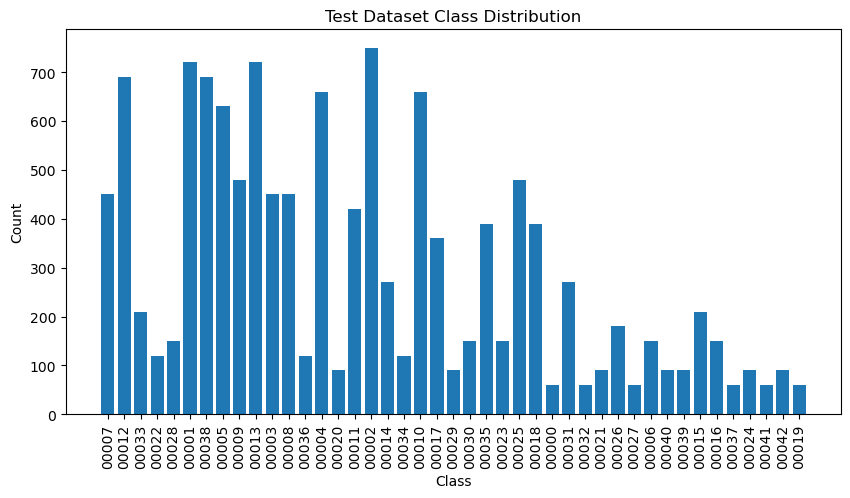

In [32]:
test_class_distribution = {}
for images, labels in test_ds:
    for label in labels.numpy():
        class_name = classes[label]
        if class_name in test_class_distribution:
            test_class_distribution[class_name] += 1
        else:
            test_class_distribution[class_name] = 1
#print(test_class_distribution)         
plot_distribution(test_class_distribution,'Test Dataset Class Distribution')

In [9]:
train_ds, validation_ds = create_validation_set(train_ds,0.2)

In [10]:
print('Number of batches train: ', train_ds.cardinality().numpy())
print('Number of batches validation: ',validation_ds.cardinality().numpy())
print('Number of batches test: ',test_ds.cardinality().numpy())

Number of batches train:  980
Number of batches validation:  246
Number of batches test:  395


In [11]:
# Normalize method
def normalize(images,labels):
    images = tf.cast(images,tf.float32)
    images /=255
    return images, labels

train_ds = train_ds.map(normalize,num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(normalize,num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(normalize,num_parallel_calls=AUTOTUNE)


In [12]:
def one_hot_encode(image,label):
    label = tf.one_hot(label,depth=NUM_CLASSES)
    return image, label


train_enc_ds = train_ds.map(one_hot_encode,num_parallel_calls=AUTOTUNE)
validation_enc_ds = validation_ds.map(one_hot_encode,num_parallel_calls=AUTOTUNE)

In [14]:
train_enc_ds = train_enc_ds.cache().shuffle(buffer_size=10200)
train_enc_ds = train_enc_ds.cache().prefetch(buffer_size=AUTOTUNE)

validation_enc_ds = validation_enc_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
test_enc_ds = test_ds.map(one_hot_encode,num_parallel_calls=AUTOTUNE)
test_enc_ds = test_enc_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Callback method
- Avoiding overfitting
- early stopping when validation accuracy no longer drops for a number of epochs
- record session to be available on tensorboard.

cd into log directory and <: tensorboard --logdir logs/path

In [16]:
def prepareCallbacks(path,log_and_model_path):

    file_path = f'{log_and_model_path}/{path}/cp.ckpt'

    checkpointer = ModelCheckpoint(filepath= file_path, 
                                monitor = 'val_accuracy',
                                verbose=1, 
                                save_weights_only=True,
                                save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_accuracy', min_delta = 0.0001, patience = 8, verbose = 1)

    tbCallBack = TensorBoard(log_dir=f'{log_and_model_path}/{path}_log', histogram_freq=0, write_graph=True, write_images=True)

    return file_path, [checkpointer, earlyStopper,tbCallBack] #, tbCallBack

## Model 1 named ModelS (model2 from the classes) and stats display

In [23]:
def modelS(classCount, imgSize, channels):
    model = Sequential()
    model.add(Input(shape=(imgSize, imgSize, channels)))

    model.add(Conv2D(64, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    
    model.add(Conv2D(64, (5, 5) )) 
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5) ) )   
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))             
    model.add(Dropout(0.2))

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model

In [24]:
modelS = modelS(43, 32, 3)
print(modelS.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        4864      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        102464    
                                                                 
 batch_normalization_4 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 64)       

In [25]:
file_pathMS, callbacksMS = prepareCallbacks('bestMS',log_and_model_pathS)

In [26]:
historyVS = modelS.fit(train_enc_ds,
          epochs=40, 
          validation_data = validation_enc_ds, 
          callbacks=callbacksMS)

979/980 [============================>.] - ETA: 0s - loss: 1.1316 - accuracy: 0.7195
Epoch 1: val_accuracy improved from -inf to 0.96024, saving model to logs/baselineModelLogs/modelS/bestMS\cp.ckpt
980/980 [==============================] - 97s 99ms/step - loss: 1.1309 - accuracy: 0.7197 - val_loss: 0.2403 - val_accuracy: 0.9602
Epoch 2/40
980/980 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9526
Epoch 2: val_accuracy improved from 0.96024 to 0.98780, saving model to logs/baselineModelLogs/modelS/bestMS\cp.ckpt
980/980 [==============================] - 66s 67ms/step - loss: 0.2152 - accuracy: 0.9526 - val_loss: 0.0835 - val_accuracy: 0.9878
Epoch 3/40
980/980 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9778
Epoch 3: val_accuracy improved from 0.98780 to 0.99200, saving model to logs/baselineModelLogs/modelS/bestMS\cp.ckpt
980/980 [==============================] - 92s 94ms/step - loss: 0.1044 - accuracy: 0.9778 - val_loss: 0.0485

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


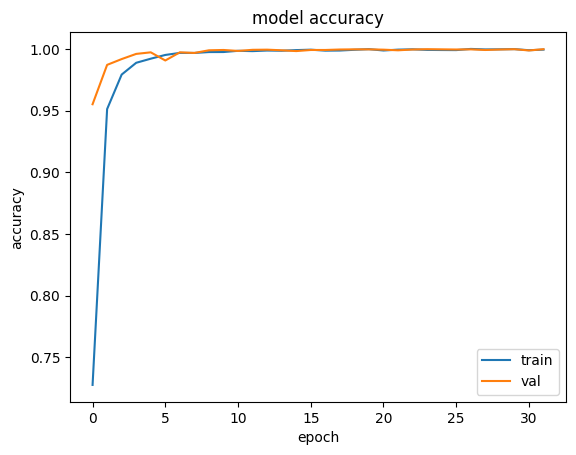

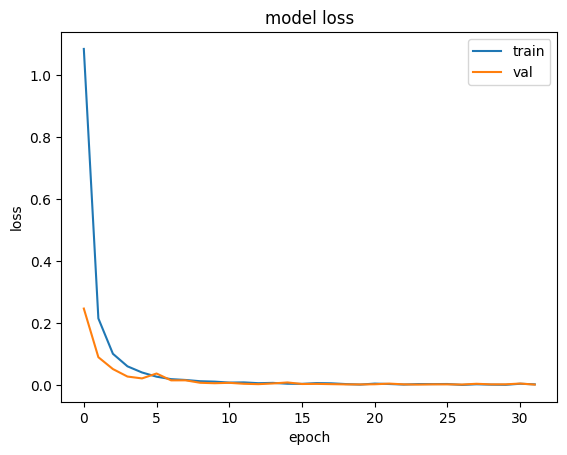

In [31]:
show_history(historyVS)

In [34]:
modelS.load_weights(file_pathMS)

evalVS = modelS.evaluate(test_enc_ds, verbose=2)
print(evalVS)
valV2 = modelS.evaluate(validation_enc_ds, verbose=2)
print(valVS)
tvalV2 = modelS.evaluate(train_enc_ds, verbose=2)
print(tvalVS)

395/395 - 20s - loss: 0.1041 - accuracy: 0.9789 - 20s/epoch - 50ms/step
[0.1041174829006195, 0.9789390563964844]
246/246 - 9s - loss: 0.0011 - accuracy: 0.9995 - 9s/epoch - 36ms/step
[0.0011268152156844735, 0.9994918704032898]
980/980 - 40s - loss: 0.0018 - accuracy: 0.9996 - 40s/epoch - 41ms/step
[0.0018374830251559615, 0.9996489882469177]


## Model 2 - Notebook from Kaggle (https://www.kaggle.com/code/shivank856/gtsrb-cnn-98-test-accuracy/notebook)
##### Why the learning rate decay?
- Early in the training process, when we are far from the optimal solution, we can afford to make large updates to our model parameters. This allows the model to learn more quickly. However, as we get closer to the optimal solution, our updates need to become more fine-grained. If the updates are too large, we risk overshooting the optimal solution.

- Starting with a large learning rate and decreasing it over time, we can make large updates in the beginning but smaller, more precise updates later on

In [21]:
def modelK(classCount, imgSize,channels):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(imgSize, imgSize, channels)))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(classCount, activation='softmax'))
    
    lr = 0.001
    epochs = 30
    opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [22]:
modelK = modelK(43, 32, 3)
print(modelK.summary())

ValueError: decay is deprecated in the new Keras optimizer, pleasecheck the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [38]:
file_pathMK, callbacksMK = prepareCallbacks('bestMK',log_and_model_pathK)

In [25]:
historyVK = modelK.fit(train_enc_ds,
          epochs=40, 
          validation_data = validation_enc_ds, 
          callbacks=callbacksMK)

Epoch 1/40
980/980 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.9123
Epoch 1: val_accuracy improved from -inf to 0.99454, saving model to logs/modelK/bestMK\cp.ckpt
980/980 [==============================] - 144s 123ms/step - loss: 0.3346 - accuracy: 0.9123 - val_loss: 0.0204 - val_accuracy: 0.9945
Epoch 2/40
980/980 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9900
Epoch 2: val_accuracy improved from 0.99454 to 0.99492, saving model to logs/modelK/bestMK\cp.ckpt
980/980 [==============================] - 109s 111ms/step - loss: 0.0330 - accuracy: 0.9900 - val_loss: 0.0169 - val_accuracy: 0.9949
Epoch 3/40
980/980 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9942
Epoch 3: val_accuracy did not improve from 0.99492
980/980 [==============================] - 136s 138ms/step - loss: 0.0209 - accuracy: 0.9942 - val_loss: 0.0370 - val_accuracy: 0.9874
Epoch 4/40
980/980 [==============================] - ETA: 0s

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


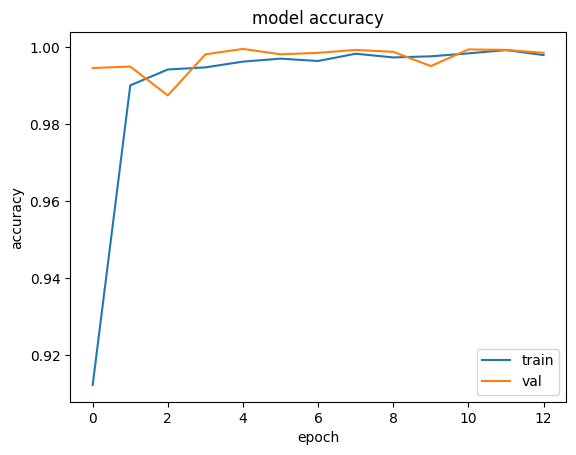

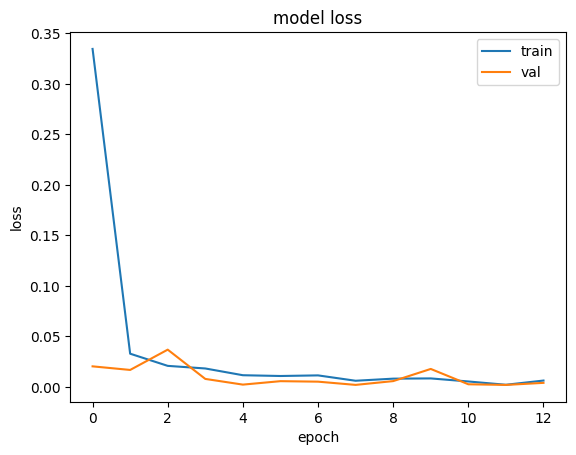

In [26]:
show_history(historyVK)

In [39]:
modelK.load_weights(file_pathMK)

evalVK = modelK.evaluate(test_enc_ds, verbose=2)
print(evalVK)
valVK = modelK.evaluate(validation_enc_ds, verbose=2)
print(valVK)
tvalVK = modelK.evaluate(train_enc_ds, verbose=2)
print(tvalVK)

395/395 - 13s - loss: 0.1158 - accuracy: 0.9736 - 13s/epoch - 33ms/step
[0.11579129099845886, 0.9735550284385681]
246/246 - 10s - loss: 0.0019 - accuracy: 0.9995 - 10s/epoch - 39ms/step
[0.0018689022399485111, 0.9994918704032898]
980/980 - 36s - loss: 0.0033 - accuracy: 0.9990 - 36s/epoch - 37ms/step
[0.003281280165538192, 0.9990426898002625]


1/1 [==============================] - 0s 62ms/step


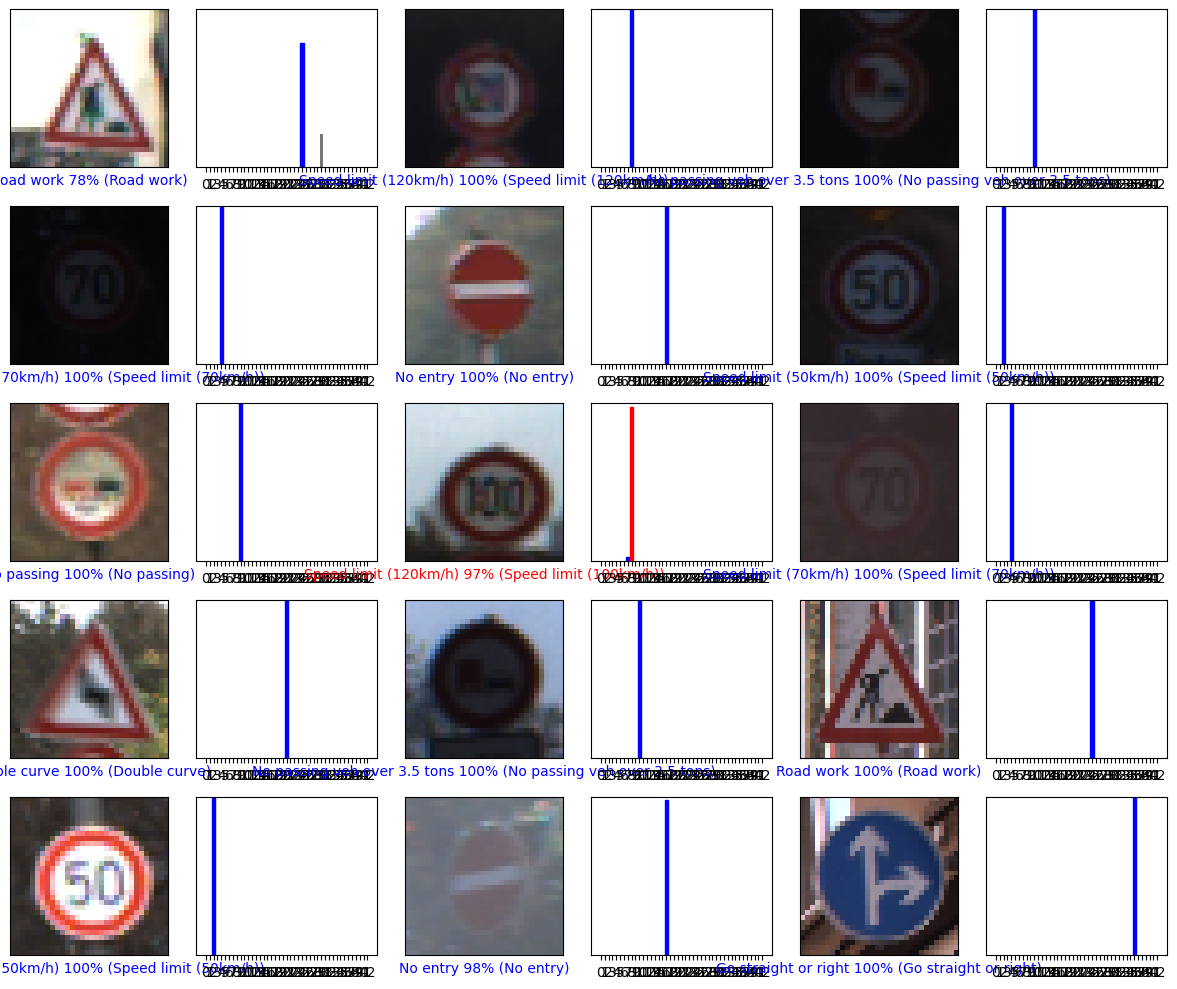

1/1 [==============================] - 0s 59ms/step


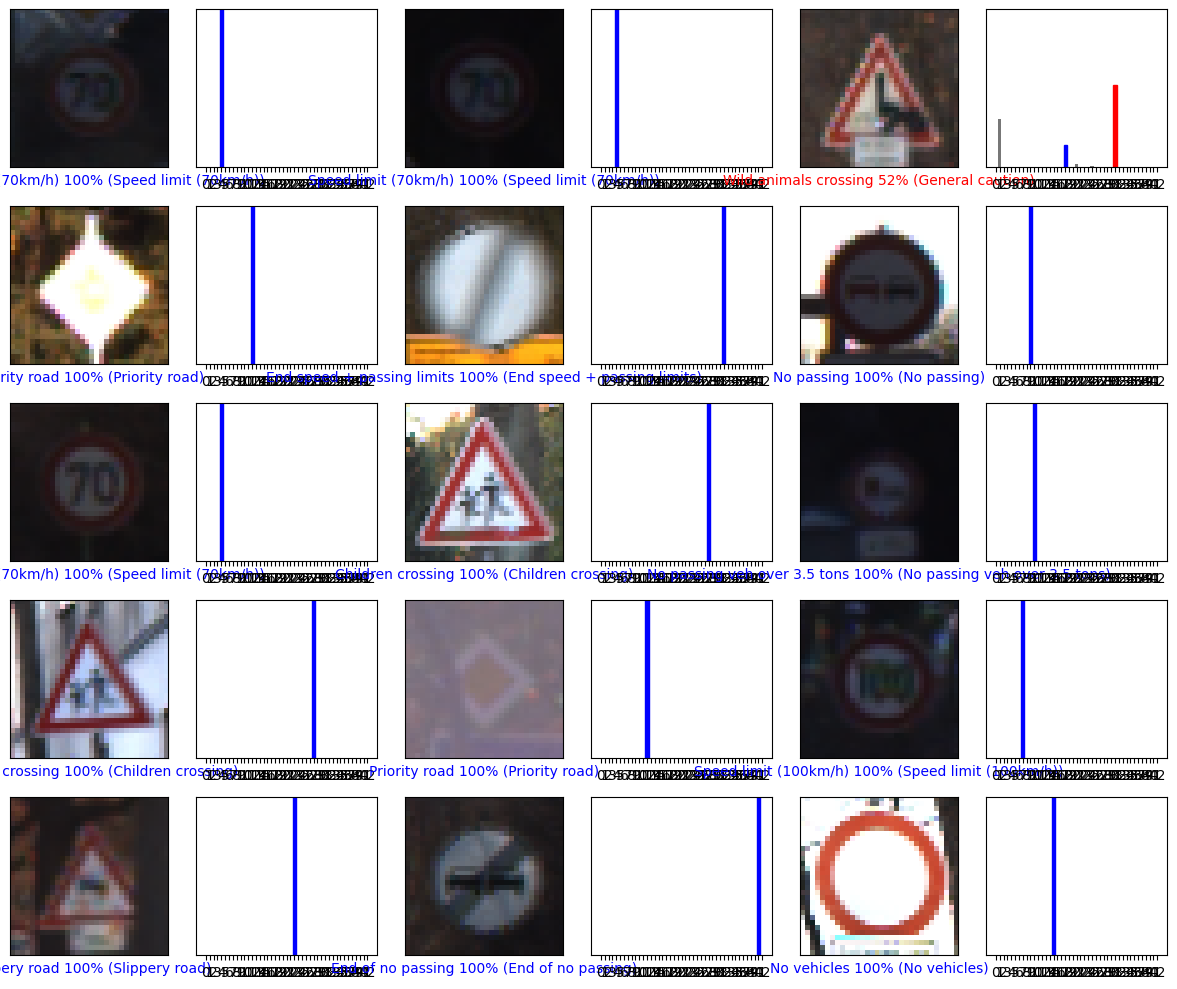

In [42]:
for images, labels in test_enc_ds.take(2):  # take n batches of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    
    preds = modelK.predict(numpy_images)  
    plot_predictions(preds, numpy_labels, numpy_images, 5, 3)

## Self model created: modelGr


In [17]:
def modelGr(classCount, imgSize,channels):
    model = Sequential()
    model.add(Input(shape=(imgSize, imgSize, channels)))

    # smaller to 
    model.add(Conv2D(32, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    #  introduce MaxPooling layers too frequently could result in loss of valuable information
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Smaller filters
    #model.add(Conv2D(64, (3, 3)))         
    #model.add(BatchNormalization())
    #model.add(Activation('relu'))   
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (5, 5)))         
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))   
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))           
    model.add(Dropout(0.4))

    model.add(Dense(classCount, activation='softmax'))

    opt = Adam(lr=0.0001) # Same learning rate and decay as ModelK
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model
    

In [18]:
modelGr = modelGr(43, 32, 3)
print(modelGr.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 24, 64)        0

c:\Users\USER\Documents\GitHub\VCPI-uminho\computer-vision\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [19]:
file_pathMGr, callbacksMGr = prepareCallbacks('bestGr2_32',log_and_model_pathGr)

In [20]:
historyVGr = modelGr.fit(train_enc_ds,
          epochs=40, 
          validation_data = validation_enc_ds, 
          callbacks=callbacksMGr)

980/980 [==============================] - ETA: 0s - loss: 0.8655 - accuracy: 0.7744
Epoch 1: val_accuracy improved from -inf to 0.97599, saving model to logs/baselineModelLogs/modelGr/bestGr2_32\cp.ckpt
980/980 [==============================] - 143s 125ms/step - loss: 0.8655 - accuracy: 0.7744 - val_loss: 0.1289 - val_accuracy: 0.9760
Epoch 2/40
980/980 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9638
Epoch 2: val_accuracy improved from 0.97599 to 0.99212, saving model to logs/baselineModelLogs/modelGr/bestGr2_32\cp.ckpt
980/980 [==============================] - 95s 97ms/step - loss: 0.1412 - accuracy: 0.9638 - val_loss: 0.0469 - val_accuracy: 0.9921
Epoch 3/40
980/980 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9843
Epoch 3: val_accuracy improved from 0.99212 to 0.99505, saving model to logs/baselineModelLogs/modelGr/bestGr2_32\cp.ckpt
980/980 [==============================] - 82s 83ms/step - loss: 0.0675 - accuracy: 0.9843 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


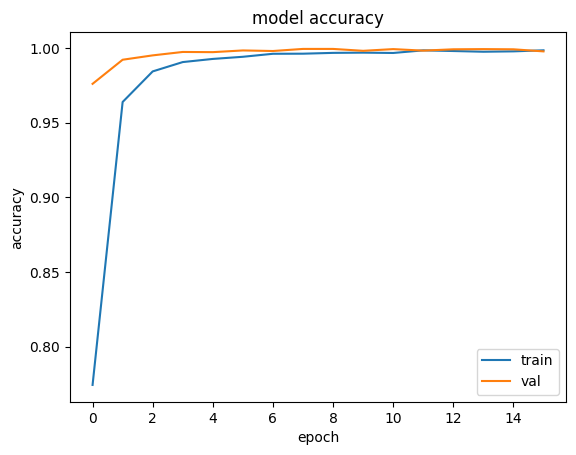

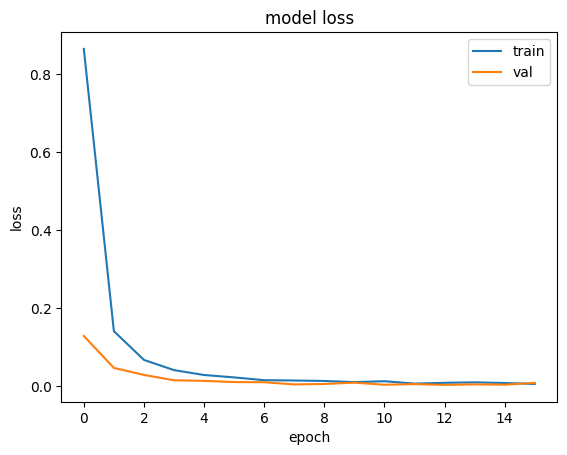

In [21]:
show_history(historyVGr)

In [22]:
modelGr.load_weights(file_pathMGr)

evalVGr = modelGr.evaluate(test_enc_ds, verbose=2)
print(evalVGr)
valVGr = modelGr.evaluate(validation_enc_ds, verbose=2)
print(valVGr )
tvalVGr = modelGr.evaluate(train_enc_ds, verbose=2)
print(tvalVGr)

395/395 - 22s - loss: 0.1142 - accuracy: 0.9738 - 22s/epoch - 55ms/step
[0.11424893140792847, 0.973792552947998]
246/246 - 11s - loss: 0.0046 - accuracy: 0.9994 - 11s/epoch - 43ms/step
[0.004602313973009586, 0.9993648529052734]
980/980 - 37s - loss: 0.0027 - accuracy: 0.9996 - 37s/epoch - 38ms/step
[0.00269248615950346, 0.9995535612106323]


c:\Users\USER\Documents\GitHub\VCPI-uminho\computer-vision\.venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


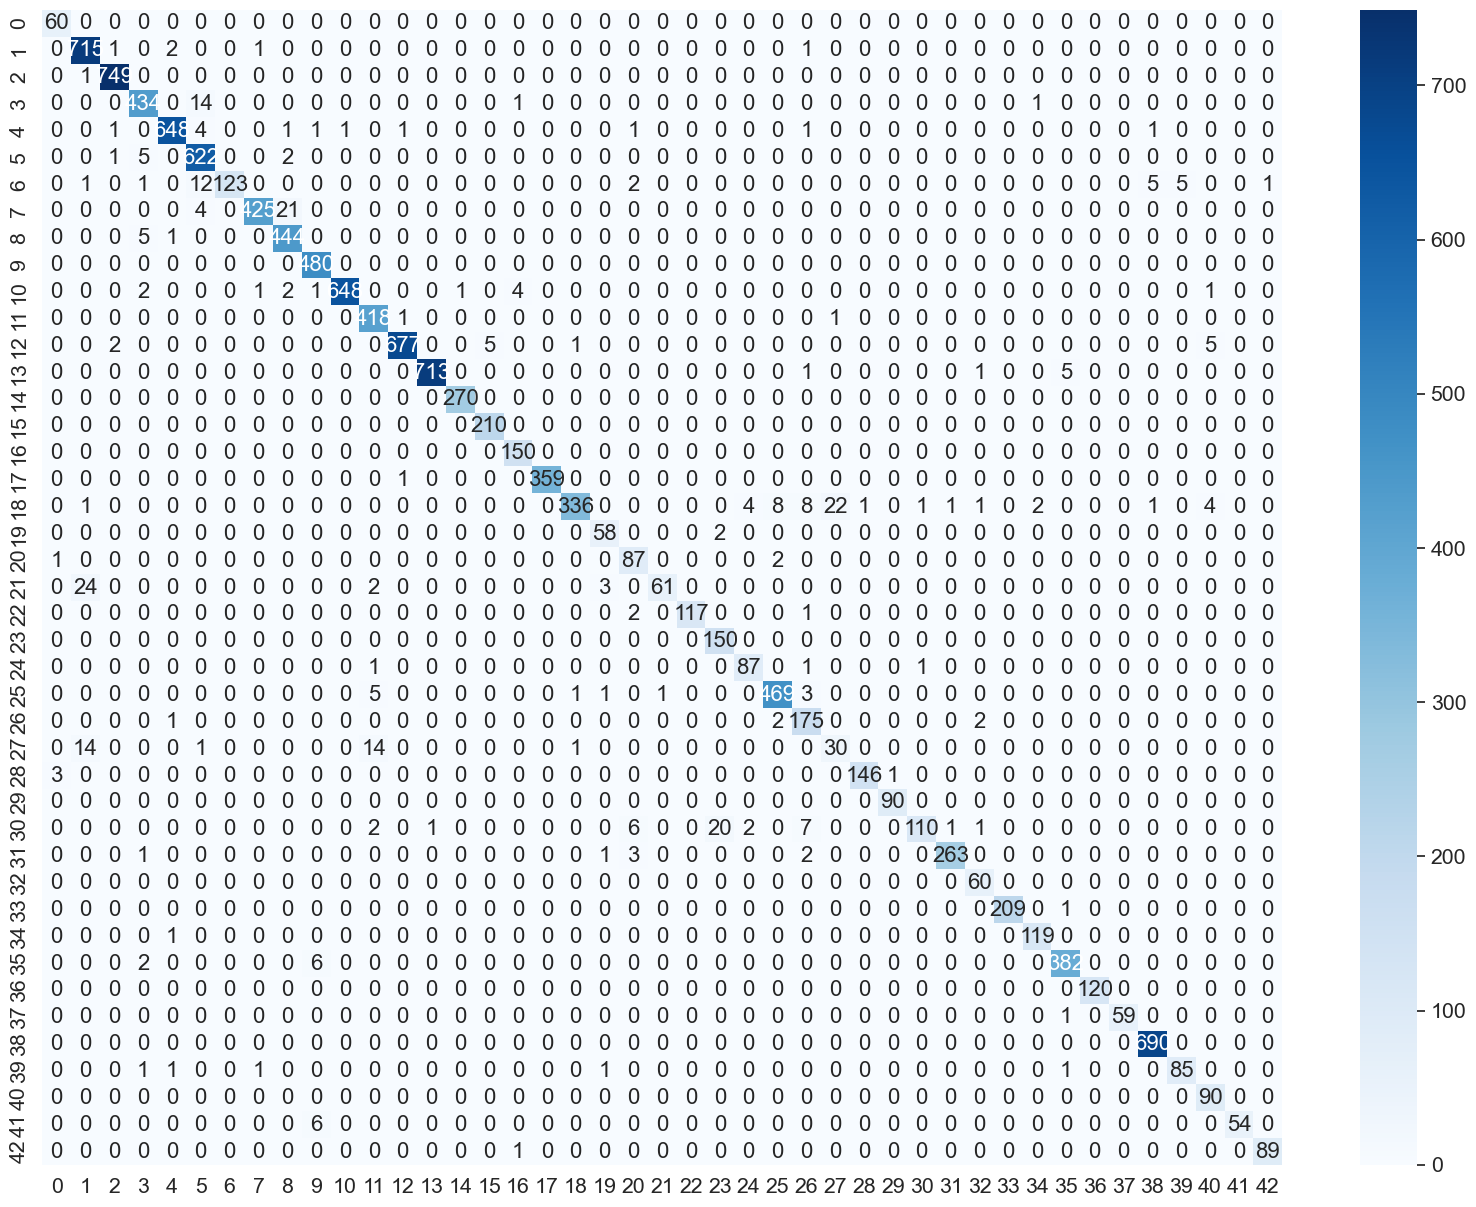

class:  0  total images:  60  % correct:  1.0
class:  1  total images:  720  % correct:  0.9930555555555556
class:  2  total images:  750  % correct:  0.9986666666666667
class:  3  total images:  450  % correct:  0.9644444444444444
class:  4  total images:  660  % correct:  0.9818181818181818
class:  5  total images:  630  % correct:  0.9873015873015873
class:  6  total images:  150  % correct:  0.82
class:  7  total images:  450  % correct:  0.9444444444444444
class:  8  total images:  450  % correct:  0.9866666666666667
class:  9  total images:  480  % correct:  1.0
class:  10  total images:  660  % correct:  0.9818181818181818
class:  11  total images:  420  % correct:  0.9952380952380953
class:  12  total images:  690  % correct:  0.981159420289855
class:  13  total images:  720  % correct:  0.9902777777777778
class:  14  total images:  270  % correct:  1.0
class:  15  total images:  210  % correct:  1.0
class:  16  total images:  150  % correct:  1.0
class:  17  total images:  360

In [53]:
show_confusion_matrix(modelGr, test_enc_ds)

### Models comparison - baseline

In [ ]:
show_accuracies(['VmodelS', 'VmodelK', 'VmodelGr'], [evalVS[1], evalVK[1], evalVGr[1]], [valVS[1], valVK[1], valVGr[1]])